<a href="https://colab.research.google.com/github/vkislinskii/m598_intermittent_demand_forecasting/blob/main/thesis_3_raf_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Importing libraries

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, recall_score, f1_score

!pip install statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, CrostonOptimized, TSB, ADIDA, IMAPA
from xgboost import XGBRegressor

! pip install catboost
from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool

!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x79b38db154e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.12/dist-packages/scipy.libs/libscipy_openblas-b75cc656.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.2 MB/s eta 0:00:00


#1. Reading data

In [2]:
drive.mount('/content/drive')
df_data = pd.read_excel("/content/drive/MyDrive/202507_thesis/data - raf/RAF.xls", dtype={'PRICE (£)': str})

Mounted at /content/drive


#2. Preprocessing data

In [3]:
df_data.columns = df_data.columns.str.replace(' ', '_').str.lower()
df_data = df_data.rename(columns={'item_ref_no': 'unique_id', 'lead_time_(months)': 'lead_time', 'price_(£)': 'price'})

In [4]:
#converting the price to normal format
for i in range(df_data.shape[0]):
  if len(df_data.price[i].split('.')[-1]) >= 3:
    df_data.loc[i, 'price'] = float(df_data.price[i]) * 1000
  else:
    df_data.loc[i, 'price'] = float(df_data.price[i])

In [5]:
#transposing the table
id_vars = ['unique_id', 'description',	'lead_time',	'price']
value_vars = df_data.select_dtypes(include=['int64']).columns
df_data2 = df_data.melt(id_vars=id_vars, value_vars=value_vars, var_name="ds", value_name="y")

df_data2['ds'] = pd.to_datetime(df_data2['ds'], format='%b%y')

In [7]:
#make the first non-zero demand the initial value
df_data_fin_start = df_data2.query("y != 0")[['unique_id', 'ds']].groupby(by="unique_id", observed=False, as_index=False).min().rename(columns={"ds": "ds_start"})
df_data2 = df_data2.merge(df_data_fin_start, on=['unique_id'], how='left').query("ds >= ds_start")

df_data_fin = df_data2[['unique_id', 'ds', 'y']]

#3. Data exploration

In [ ]:
df_plot = df_data2.pivot(index="ds", columns="unique_id", values="y")

In [ ]:
def compute_p_v_from_series(series: pd.Series, ddof: int = 1):
    series = series.dropna()
    T = len(series)
    positives = series[series > 0]
    m = int(positives.count())
    if m == 0:
        return {"T": T, "m": 0, "p": np.nan, "mu": np.nan, "var": np.nan, "v": np.nan}
    p = T / m
    mu = float(positives.mean())
    if m > ddof:
        var = float(positives.var(ddof=ddof))
        v = var / (mu**2) if mu != 0 else np.inf
    else:
        var = np.nan
        v = np.nan
    return {"T": T, "m": m, "p": p, "mu": mu, "var": var, "v": v}

In [ ]:
ddof=1
sort_by='p'
results = []
n = 0
for col in df_plot.columns:
  res = compute_p_v_from_series(df_plot[col], ddof=ddof)
  res["item"] = col
  results.append(res)

results_df = pd.DataFrame(results).set_index("item")
results_df = results_df[["T", "m", "p", "mu", "var", "v"]]

if sort_by in results_df.columns:
  results_df_sorted = results_df.sort_values(sort_by, ascending=False)
else:
  results_df_sorted = results_df.copy()

results_df_sorted['ln_p'] = np.log(results_df_sorted.p)
results_df_sorted['ln_v'] = np.log(results_df_sorted.v)

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
smo = results_df_sorted.query("p <= 1.32 & v <= 0.49").shape[0]
inte = results_df_sorted.query("p > 1.32 & v <= 0.49").shape[0]
err = results_df_sorted.query("p <= 1.32 & v > 0.49").shape[0]
lum = results_df_sorted.query("p > 1.32 & v > 0.49").shape[0]

print(f"{smo} - Smooth \n{inte} - Intermittent\n{err} - Erratic\n{lum} - Lumpy")

0 - Smooth 
2597 - Intermittent
0 - Erratic
2403 - Lumpy


In [ ]:
round(results_df_sorted[['p', 'v']].describe(), 2)

,p,v
count,5000.00,5000.00
mean,10.00,0.72
std,3.49,0.91
min,4.07,0.00
25%,7.49,0.18
50%,9.22,0.46
75%,11.86,0.90
max,24.00,11.88


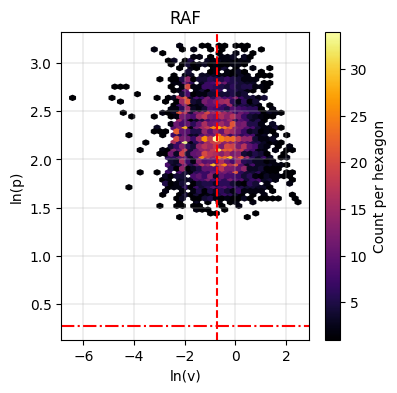

In [ ]:
y = results_df_sorted["ln_p"].values
x = results_df_sorted["ln_v"].values
labels = results_df_sorted.index.astype(str).tolist()

fig, ax = plt.subplots(figsize=(4, 4))
hb = ax.hexbin(x, y, gridsize=40, cmap="inferno", mincnt=1)

ax.set_ylabel("ln(p)") #p - average inter-demand interval
ax.set_xlabel("ln(v)") #v - squared coef of variation
ax.set_title("RAF")

ax.grid(True, linewidth=0.3)

v_thresh = 0.27763
p_thresh = -0.71334

# vertical and horizontal lines at the borders
ax.axvline(x=p_thresh, color="red", linestyle="--", linewidth=1.5, label=f"p = {p_thresh}")
ax.axhline(y=v_thresh, color="red", linestyle="-.", linewidth=1.5, label=f"v = {v_thresh}")

plt.colorbar(hb, ax=ax, label="Count per hexagon")

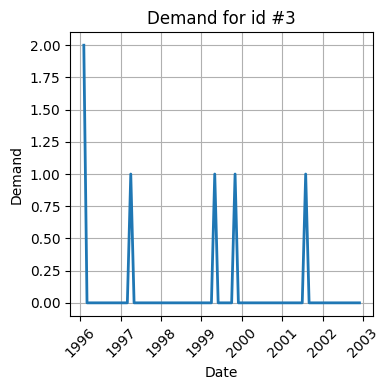

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(df_data2.query("unique_id == 3").ds, df_data2.query("unique_id == 3").y, linestyle="-", linewidth=2)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Demand for id #3")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

#4. Feature engineering

##4.1. New features

In [9]:
#additional features for CatBoost
df_data2['y_bin'] = np.where(df_data2['y'] > 0, 1, 0)

df_data2['month'] = df_data2['ds'].dt.month
df_data2['quarter'] = df_data2['ds'].dt.quarter
df_data2['year'] = df_data2['ds'].dt.year

df_data2 = df_data2.sort_values(['unique_id', 'ds'])

#lag features
df_data2['qty_lag1'] = df_data2.groupby('unique_id')['y'].shift(1)
df_data2['qty_lag2'] = df_data2.groupby('unique_id')['y'].shift(2)
df_data2['qty_lag3'] = df_data2.groupby('unique_id')['y'].shift(3)
df_data2['bin_lag1'] = df_data2.groupby('unique_id')['y_bin'].shift(1)
df_data2['bin_lag2'] = df_data2.groupby('unique_id')['y_bin'].shift(2)
df_data2['bin_lag3'] = df_data2.groupby('unique_id')['y_bin'].shift(3)

#rolling means
df_data2['qty_roll_mean_3'] = df_data2.groupby('unique_id')['y'].rolling(window=3, closed='left').mean().reset_index(0, drop=True)
df_data2['bin_roll_mean_3'] = df_data2.groupby('unique_id')['y_bin'].rolling(window=3, closed='left').mean().reset_index(0, drop=True)
df_data2['qty_roll_mean_6'] = df_data2.groupby('unique_id')['y'].rolling(window=6, closed='left').mean().reset_index(0, drop=True)
df_data2 = df_data2.fillna(0)

#trend features
df_data2['qty_diff1'] = df_data2['qty_lag1'] - df_data2['qty_lag2']
df_data2['qty_trend_ratio'] = df_data2['qty_roll_mean_3'] / (df_data2['qty_roll_mean_6'] + 1e-6)

##4.2. Train-test splitting

In [ ]:
#validation - 15.7% of the dataset
h = 12
split_day = df_data_fin.ds.max() - pd.DateOffset(months=h)
split_day_val = df_data2.ds.max() - pd.DateOffset(months=(h + 12))

In [ ]:
#train-test for univariate models
train = df_data_fin.query("ds <= @split_day")
test = df_data_fin.query("ds > @split_day")

In [ ]:
#train-test for boosting
train_cat = df_data2.query("ds <= @split_day_val").copy()
val_cat = df_data2.query("ds > @split_day_val & ds <= @split_day").copy()
test_cat = df_data2.query("ds > @split_day").copy()

#5. Predictions

##5.1. RMSSE metric function defining

In [ ]:
#RMSSE metric calculation
def fast_rmsse(df_hist, df_forecasts, df_test, forecast_col):
    hist_df = df_hist.pivot(index='ds', columns='unique_id', values='y').sort_index()
    test_df = df_test.pivot(index='ds', columns='unique_id', values='y').sort_index()
    pred_df = df_forecasts.pivot(index='ds', columns='unique_id', values=forecast_col).sort_index()

    #align columns across datsframes
    cols = hist_df.columns
    test_df = test_df.reindex(columns=cols)
    pred_df = pred_df.reindex(columns=cols)

    #convert to numpy for calculation
    hist_wide = hist_df.to_numpy(dtype=float)
    test_wide = test_df.to_numpy(dtype=float)
    pred_wide = pred_df.to_numpy(dtype=float)

    #denominator
    diffsq = np.diff(hist_wide, axis=0) ** 2
    denom = np.nanmean(diffsq, axis=0)

    #numerator (mean squared forecast errors)
    num = np.nanmean((test_wide - pred_wide) ** 2, axis=0)

    #calculation
    bad = (denom == 0) | np.isnan(denom)
    rmsse = np.sqrt(num / denom)
    rmsse[bad] = np.nan

    return rmsse, cols

##5.2. ETS, SBA, TSB, ADIDA, IMAPA

In [ ]:
sf = StatsForecast(
    models=[
        CrostonOptimized(alias='SBA'),
        TSB(alpha_d=0.2, alpha_p=0.2),
        ADIDA(),
        IMAPA(),
        AutoETS(season_length=12)
        ],
    freq='MS',
    n_jobs=1
)

In [ ]:
fitted = sf.fit(train)
forecasts = fitted.forecast(df=train, h=h)

In [ ]:
merged = forecasts.merge(test, on=['unique_id', 'ds'], how='left')
merged['SBA_round'] = np.round(merged['SBA']).astype('uint16')
merged['TSB_round'] = np.round(merged['TSB']).astype('uint16')
merged['ADIDA_round'] = np.round(merged['ADIDA']).astype('uint16')
merged['IMAPA_round'] = np.round(merged['IMAPA']).astype('uint16')
merged['ETS_round'] = np.round(merged['AutoETS']).astype('int16')

In [ ]:
#RMSSE - float prediction
r_vec_sba, cols_sba = fast_rmsse(train, merged, test, 'SBA')
r_vec_tsb, cols_tsb = fast_rmsse(train, merged, test, 'TSB')
r_vec_adida, cols_adida = fast_rmsse(train, merged, test, 'ADIDA')
r_vec_imapa, cols_imapa = fast_rmsse(train, merged, test, 'IMAPA')
r_vec_ets, cols_ets = fast_rmsse(train, merged, test, 'AutoETS')

print(f"RMSSE CrostonSBA for h={h}: {np.nanmean(r_vec_sba):.3f}")
print(f"RMSSE TSB for h={h}: {np.nanmean(r_vec_tsb):.3f}")
print(f"RMSSE ADIDA for h={h}: {np.nanmean(r_vec_adida):.3f}")
print(f"RMSSE IMAPA for h={h}: {np.nanmean(r_vec_imapa):.3f}")
print(f"RMSSE ETS for h={h}: {np.nanmean(r_vec_ets):.3f}")

RMSSE CrostonSBA for h=3: 0.512
RMSSE TSB for h=3: 0.456
RMSSE ADIDA for h=3: 0.466
RMSSE IMAPA for h=3: 0.462
RMSSE ETS for h=3: 0.482


In [ ]:
#RMSSE - integer prediction
r_vec_sba, cols_sba = fast_rmsse(train, merged, test, 'SBA_round')
r_vec_tsb, cols_tsb = fast_rmsse(train, merged, test, 'TSB_round')
r_vec_adida, cols_adida = fast_rmsse(train, merged, test, 'ADIDA_round')
r_vec_imapa, cols_imapa = fast_rmsse(train, merged, test, 'IMAPA_round')
r_vec_ets, cols_ets = fast_rmsse(train, merged, test, 'ETS_round')

print(f"RMSSE CrostonSBA for h={h}: {np.nanmean(r_vec_sba):.3f}")
print(f"RMSSE TSB for h={h}: {np.nanmean(r_vec_tsb):.3f}")
print(f"RMSSE ADIDA for h={h}: {np.nanmean(r_vec_adida):.3f}")
print(f"RMSSE IMAPA for h={h}: {np.nanmean(r_vec_imapa):.3f}")
print(f"RMSSE ETS for h={h}: {np.nanmean(r_vec_ets):.3f}")

RMSSE CrostonSBA for h=3: 0.434
RMSSE TSB for h=3: 0.409
RMSSE ADIDA for h=3: 0.400
RMSSE IMAPA for h=3: 0.399
RMSSE ETS for h=3: 0.413


In [ ]:
#MAE - float prediction
mae_sba = mean_absolute_error(merged['y'], merged['SBA'])
mae_tsb = mean_absolute_error(merged['y'], merged['TSB'])
mae_adida = mean_absolute_error(merged['y'], merged['ADIDA'])
mae_imapa = mean_absolute_error(merged['y'], merged['IMAPA'])
mae_ets = mean_absolute_error(merged['y'], merged['AutoETS'])

print(f"MAE CrostonSBA for h={h}: {mae_sba:.3f}")
print(f"MAE TSB for h={h}: {mae_tsb:.3f}")
print(f"MAE ADIDA for h={h}: {mae_adida:.3f}")
print(f"MAE IMAPA for h={h}: {mae_imapa:.3f}")
print(f"MAE ETS for h={h}: {mae_ets:.3f}")

MAE CrostonSBA for h=3: 2.767
MAE TSB for h=3: 2.379
MAE ADIDA for h=3: 2.419
MAE IMAPA for h=3: 2.400
MAE ETS for h=3: 2.573


In [ ]:
#MAE - integer prediction
mae_sba = mean_absolute_error(merged['y'], merged['SBA_round'])
mae_tsb = mean_absolute_error(merged['y'], merged['TSB_round'])
mae_adida = mean_absolute_error(merged['y'], merged['ADIDA_round']) #merged forecasts
mae_imapa = mean_absolute_error(merged['y'], merged['IMAPA_round'])
mae_ets = mean_absolute_error(merged['y'], merged['ETS_round'])

print(f"MAE CrostonSBA for h={h}: {mae_sba:.3f}")
print(f"MAE TSB for h={h}: {mae_tsb:.3f}")
print(f"MAE ADIDA for h={h}: {mae_adida:.3f}")
print(f"MAE IMAPA for h={h}: {mae_imapa:.3f}")
print(f"MAE ETS for h={h}: {mae_ets:.3f}")

MAE CrostonSBA for h=3: 2.693
MAE TSB for h=3: 2.321
MAE ADIDA for h=3: 2.339
MAE IMAPA for h=3: 2.323
MAE ETS for h=3: 2.498


##5.3. XGBoost, CatBoost regressors

###XGB

#### With initial features

In [ ]:
train_cat['description'] = train_cat['description'].astype("category")
val_cat['description'] = val_cat['description'].astype("category")
test_cat['description'] = test_cat['description'].astype("category")

In [ ]:
#set of initial features
X = ['unique_id', 'description',	'lead_time',	'price', 'year', 'month']
y = 'y'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
base_model = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    early_stopping_rounds=200,
    objective='reg:squarederror',  # optimizes MSE
    eval_metric='rmse', #MAE R2
    random_state=42,
    enable_categorical=True
)

base_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=200,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
print(round(base_model.best_score, 5), base_model.best_iteration)

14.01954 9


In [ ]:
# Predict
y_pred_val = base_model.predict(X_val)

val_cat['XGB_val'] = y_pred_val
val_cat['XGB_val'] = np.where(val_cat['XGB_val'] < 0, 0, val_cat['XGB_val'])
val_cat['XGB_val_round'] = np.round(val_cat['XGB_val']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'XGB_val')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

#RMSSE, MAE - integer prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'XGB_val_round')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

RMSSE CatBoostRegressor for h=12: 1.409
RMSSE CatBoostRegressor for h=12: 1.228


#####final evaluation on test (if applicable)

In [ ]:
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = pd.concat([y_train, y_val], ignore_index=True)

In [ ]:
final_model_xgb = XGBRegressor(
    n_estimators=base_model.best_iteration,
    max_depth=6,
    learning_rate=0.05,
    objective='reg:squarederror',  # optimizes MSE
    eval_metric='rmse', #MAE R2
    random_state=42,
    enable_categorical=True
)

final_model_xgb.fit(
    X_trainval, y_trainval,
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=9,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predict
y_pred_xgb = final_model_xgb.predict(X_test)

test_cat['XGB'] = y_pred_xgb
test_cat['XGB'] = np.where(test_cat['XGB'] < 0, 0, test_cat['XGB'])
test_cat['XGB_round'] = np.round(test_cat['XGB']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_xgb, cols_xgb = fast_rmsse(train, test_cat, test_cat, 'XGB')
mae_xgb = mean_absolute_error(test_cat['y'], test_cat['XGB'])
print(f"RMSSE XGBRegressor for h={h}: {np.nanmean(r_vec_xgb):.3f}")
print(f"MAE XGBRegressor for h={h}: {mae_xgb:.3f}")

#RMSSE, MAE - integer prediction
r_vec_xgb, cols_xgb = fast_rmsse(train, test_cat, test_cat, 'XGB_round')
mae_xgb = mean_absolute_error(test_cat['y'], test_cat['XGB_round'])
print(f"RMSSE XGBRegressor for h={h}: {np.nanmean(r_vec_xgb):.3f}")
print(f"MAE XGBRegressor for h={h}: {mae_xgb:.3f}")

RMSSE XGBRegressor for h=12: 1.268
MAE XGBRegressor for h=12: 2.533
RMSSE XGBRegressor for h=12: 1.101
MAE XGBRegressor for h=12: 2.356


####With additional features

In [ ]:
train_cat['ds_month'] = df_data2['ds_start'].dt.month
train_cat['ds_year'] = df_data2['ds_start'].dt.year
val_cat['ds_month'] = df_data2['ds_start'].dt.month
val_cat['ds_year'] = df_data2['ds_start'].dt.year
test_cat['ds_month'] = df_data2['ds_start'].dt.month
test_cat['ds_year'] = df_data2['ds_start'].dt.year
train_cat['description'] = train_cat['description'].astype("category")
val_cat['description'] = val_cat['description'].astype("category")
test_cat['description'] = test_cat['description'].astype("category")

In [ ]:
#set of all features
X = train_cat.drop(columns=['y', 'y_bin', 'ds', 'ds_start']).columns.tolist()
y = 'y'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
full_model = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    early_stopping_rounds=200,
    objective='reg:squarederror',  # optimizes MSE
    eval_metric='rmse', #MAE R2
    random_state=42,
    enable_categorical=True
)
full_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=200,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
print(round(full_model.best_score, 5), full_model.best_iteration)

14.01804 9


In [ ]:
y_pred_val = full_model.predict(X_val)

val_cat['XGB_val'] = y_pred_val
val_cat['XGB_val'] = np.where(val_cat['XGB_val'] < 0, 0, val_cat['XGB_val'])
val_cat['XGB_val_round'] = np.round(val_cat['XGB_val']).astype('uint16')

In [ ]:
baseline_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

In [ ]:
rmse_drop = {}
i = 0

#loop over each feature and calculate the difference
for feature in X_train.columns:
    X_train_drop = X_train.drop(columns=[feature])
    X_val_drop = X_val.drop(columns=[feature])

    model = XGBRegressor(
        n_estimators=1000,
        max_depth=6,
        learning_rate=0.05,
        early_stopping_rounds=200,
        objective='reg:squarederror',  # optimizes MSE
        eval_metric='rmse',
        random_state=42,
        enable_categorical=True
    )
    model.fit(
        X_train_drop, y_train,
        eval_set=[(X_val_drop, y_val)],
        verbose=False)
    y_pred = model.predict(X_val_drop)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    rmse_drop[feature] = rmse
    print(f"{i}. without {feature}, rmse diff is: {(rmse - baseline_rmse):.3f}")
    i += 1

rmse_df = pd.DataFrame({
    'feature': list(rmse_drop.keys()),
    'rmse_without_feature': list(rmse_drop.values())
})

#eventual impact (increase in RMSE when dropped)
rmse_df['rmse_increase'] = rmse_df['rmse_without_feature'] - baseline_rmse

0. without unique_id, rmse diff is: -0.001
1. without description, rmse diff is: 0.068
2. without lead_time, rmse diff is: 0.002
3. without price, rmse diff is: -0.001
4. without month, rmse diff is: -0.011
5. without quarter, rmse diff is: 0.000
6. without year, rmse diff is: 0.010
7. without qty_lag1, rmse diff is: -0.011
8. without qty_lag2, rmse diff is: -0.008
9. without qty_lag3, rmse diff is: -0.001
10. without bin_lag1, rmse diff is: 0.000
11. without bin_lag2, rmse diff is: 0.000
12. without bin_lag3, rmse diff is: 0.000
13. without qty_roll_mean_3, rmse diff is: 0.008
14. without bin_roll_mean_3, rmse diff is: 0.000
15. without qty_roll_mean_6, rmse diff is: -0.007
16. without qty_diff1, rmse diff is: -0.003
17. without qty_trend_ratio, rmse diff is: -0.001
18. without ds_month, rmse diff is: 0.005
19. without ds_year, rmse diff is: 0.000


In [ ]:
rmse_df[['feature', 'rmse_increase']].sort_values('rmse_increase', ascending=False)

,feature,rmse_increase
1,description,0.067864
6,year,0.009570
13,qty_roll_mean_3,0.008097
18,ds_month,0.005304
2,lead_time,0.001588
14,bin_roll_mean_3,0.000000
19,ds_year,0.000000
5,quarter,0.000000
12,bin_lag3,0.000000
11,bin_lag2,0.000000


In [ ]:
strong_features_xgb = rmse_df.query("rmse_increase > 0.002")['feature'].tolist()
print(f"strong features for h={h}: {strong_features_xgb}")

strong features for h=12: ['description', 'year', 'qty_roll_mean_3', 'ds_month']


In [ ]:
X = strong_features_xgb
y = 'y'

X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
opt_model = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    early_stopping_rounds=200,
    objective='reg:squarederror',  # optimizes MSE
    eval_metric='rmse', #MAE R2
    random_state=42,
    enable_categorical=True
)
opt_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=200,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
print(round(opt_model.best_score, 5), opt_model.best_iteration)

13.91665 35


In [ ]:
# Predict
y_pred_val = opt_model.predict(X_val)

val_cat['XGB_val'] = y_pred_val
val_cat['XGB_val'] = np.where(val_cat['XGB_val'] < 0, 0, val_cat['XGB_val'])
val_cat['XGB_val_round'] = np.round(val_cat['XGB_val']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'XGB_val')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

#RMSSE, MAE - integer prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'XGB_val_round')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

RMSSE CatBoostRegressor for h=12: 1.148
RMSSE CatBoostRegressor for h=12: 1.246


####With hyperparameters tuning

In [ ]:
train_cat['description'] = train_cat['description'].astype("category")
val_cat['description'] = val_cat['description'].astype("category")
test_cat['description'] = test_cat['description'].astype("category")

In [ ]:
#set of initial features
X = ['unique_id', 'description',	'lead_time',	'price', 'year', 'month']
y = 'y'

X_train = train_cat[X]
y_train = train_cat[y]
X_val = val_cat[X]
y_val = val_cat[y]
X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
#finding optimal hyperparameters
def objective_xgb(trial):
    depth = trial.suggest_int('max_depth', 4, 10)
    lr = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)

    model = XGBRegressor(
        n_estimators=1000,
        max_depth=depth,
        learning_rate=lr,
        early_stopping_rounds=200,
        objective='reg:squarederror',  # optimizes MSE
        eval_metric='rmse', #MAE R2
        random_state=42,
        enable_categorical=True
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    trial.set_user_attr("best_iteration", model.best_iteration)

    return model.best_score

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective_xgb, n_trials=20)

[I 2025-09-08 14:54:52,733] A new study created in memory with name: no-name-e84c2653-b3e6-43e3-befe-51f5fe64da8a
[I 2025-09-08 14:55:01,826] Trial 0 finished with value: 12.446860128778054 and parameters: {'max_depth': 6, 'learning_rate': 0.2536999076681772}. Best is trial 0 with value: 12.446860128778054.
[I 2025-09-08 14:55:25,764] Trial 1 finished with value: 12.511744628990707 and parameters: {'max_depth': 9, 'learning_rate': 0.07661100707771368}. Best is trial 0 with value: 12.446860128778054.
[I 2025-09-08 14:55:38,054] Trial 2 finished with value: 12.515332451953684 and parameters: {'max_depth': 5, 'learning_rate': 0.01699897838270077}. Best is trial 0 with value: 12.446860128778054.
[I 2025-09-08 14:55:44,224] Trial 3 finished with value: 12.525741360346945 and parameters: {'max_depth': 4, 'learning_rate': 0.19030368381735815}. Best is trial 0 with value: 12.446860128778054.
[I 2025-09-08 14:56:03,095] Trial 4 finished with value: 12.488877307339962 and parameters: {'max_depth

In [ ]:
best_model_xgb = XGBRegressor(
    n_estimators=1000,
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    early_stopping_rounds=200,
    objective='reg:squarederror',  # optimizes MSE
    eval_metric='rmse', #MAE R2
    random_state=42,
    enable_categorical=True
)
best_model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=200,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08798155327756996, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# Predict
y_pred_val = best_model_xgb.predict(X_val)

val_cat['XGB_val'] = y_pred_val
val_cat['XGB_val'] = np.where(val_cat['XGB_val'] < 0, 0, val_cat['XGB_val'])
val_cat['XGB_val_round'] = np.round(val_cat['XGB_val']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'XGB_val')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

#RMSSE, MAE - integer prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'XGB_val_round')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

RMSSE CatBoostRegressor for h=3: 1.044
RMSSE CatBoostRegressor for h=3: 1.122


#####final evaluation on test (if applicable)

In [ ]:
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = pd.concat([y_train, y_val], ignore_index=True)

In [ ]:
final_model_xgb = XGBRegressor(
    n_estimators=study.best_trial.user_attrs['best_iteration'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    objective='reg:squarederror',  # optimizes MSE
    eval_metric='rmse', #MAE R2
    random_state=42,
    enable_categorical=True
)

final_model_xgb.fit(
    X_trainval, y_trainval,
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08798155327756996, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=12, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# Predict
y_pred_xgb = final_model_xgb.predict(X_test)

test_cat['XGB'] = y_pred_xgb
test_cat['XGB'] = np.where(test_cat['XGB'] < 0, 0, test_cat['XGB'])
test_cat['XGB_round'] = np.round(test_cat['XGB']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_xgb, cols_xgb = fast_rmsse(train, test_cat, test_cat, 'XGB')
mae_xgb = mean_absolute_error(test_cat['y'], test_cat['XGB'])
print(f"RMSSE XGBRegressor for h={h}: {np.nanmean(r_vec_xgb):.3f}")
print(f"MAE XGBRegressor for h={h}: {mae_xgb:.3f}")

#RMSSE, MAE - integer prediction
r_vec_xgb, cols_xgb = fast_rmsse(train, test_cat, test_cat, 'XGB_round')
mae_xgb = mean_absolute_error(test_cat['y'], test_cat['XGB_round'])
print(f"RMSSE XGBRegressor for h={h}: {np.nanmean(r_vec_xgb):.3f}")
print(f"MAE XGBRegressor for h={h}: {mae_xgb:.3f}")

RMSSE XGBRegressor for h=3: 0.952
MAE XGBRegressor for h=3: 2.557
RMSSE XGBRegressor for h=3: 1.032
MAE XGBRegressor for h=3: 2.623


###CatBoost

####With initial features

In [ ]:
#set of initial features
X = ['unique_id', 'description',	'lead_time',	'price', 'ds']
cat_features = train_cat[X].select_dtypes(include=['object', 'category']).columns.tolist()
y = 'y'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
base_model = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=200,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
    )
base_model.fit(train_pool, eval_set=val_pool)

0:	learn: 18.0109561	test: 14.0838623	best: 14.0838623 (0)	total: 193ms	remaining: 3m 12s
100:	learn: 17.6922110	test: 14.0205633	best: 14.0205633 (100)	total: 13.6s	remaining: 2m 1s
200:	learn: 17.5602591	test: 13.9973084	best: 13.9972299 (196)	total: 24.3s	remaining: 1m 36s
300:	learn: 17.4096643	test: 13.9920869	best: 13.9893732 (284)	total: 33.3s	remaining: 1m 17s
400:	learn: 17.2760378	test: 13.9831115	best: 13.9817892 (396)	total: 42.5s	remaining: 1m 3s
500:	learn: 17.1223426	test: 13.9736163	best: 13.9735712 (499)	total: 51.6s	remaining: 51.4s
600:	learn: 17.0541270	test: 13.9750578	best: 13.9718344 (530)	total: 59s	remaining: 39.2s
700:	learn: 16.9724950	test: 13.9724749	best: 13.9718344 (530)	total: 1m 8s	remaining: 29.3s
800:	learn: 16.8771079	test: 13.9735107	best: 13.9698731 (790)	total: 1m 16s	remaining: 19.1s
900:	learn: 16.7643777	test: 13.9848391	best: 13.9698731 (790)	total: 1m 26s	remaining: 9.53s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 13.9

In [ ]:
y_pred_val = base_model.predict(X_val)

val_cat['CatRegr_val'] = y_pred_val
val_cat['CatRegr_val'] = np.where(val_cat['CatRegr_val'] < 0, 0, val_cat['CatRegr_val'])
val_cat['CatRegr_val_round'] = np.round(val_cat['CatRegr_val']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'CatRegr_val')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

#RMSSE, MAE - integer prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'CatRegr_val_round')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

RMSSE CatBoostRegressor for h=12: 0.903
RMSSE CatBoostRegressor for h=12: 0.912


#####final evaluation on test (if applicable)

In [ ]:
#creating the pool with train+val
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = pd.concat([y_train, y_val], ignore_index=True)
trainval_pool = Pool(X_trainval, y_trainval, cat_features=cat_features)

In [ ]:
#training on train+val with the optimal hyperparameters
final_cat_model = CatBoostRegressor(
    iterations=base_model.best_iteration_,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)
final_cat_model.fit(trainval_pool)

In [ ]:
# Predict
y_pred = final_cat_model.predict(X_test)

test_cat['CatRegr'] = y_pred
test_cat['CatRegr'] = np.where(test_cat['CatRegr'] < 0, 0, test_cat['CatRegr'])
test_cat['CatRegr_round'] = np.round(test_cat['CatRegr']).astype('uint16')

In [ ]:
#RMSSE, MAE - raw
r_vec_cat, cols_cat = fast_rmsse(train, test_cat, test_cat, 'CatRegr')
mae_cat = mean_absolute_error(test_cat['y'], test_cat['CatRegr'])
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")
print(f"MAE CatBoostRegressor for h={h}: {mae_cat:.3f}")

#RMSSE, MAE - rounded
r_vec_cat, cols_cat = fast_rmsse(train, test_cat, test_cat, 'CatRegr_round')
mae_cat = mean_absolute_error(test_cat['y'], test_cat['CatRegr_round'])
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")
print(f"MAE CatBoostRegressor for h={h}: {mae_cat:.3f}")

RMSSE CatBoostRegressor for h=12: 0.704
MAE CatBoostRegressor for h=12: 1.930
RMSSE CatBoostRegressor for h=12: 0.703
MAE CatBoostRegressor for h=12: 1.906


####With additional features

In [ ]:
#set of all features
X = train_cat.drop(columns=['y', 'y_bin']).columns.tolist()
cat_features = train_cat[X].select_dtypes(include=['object', 'category']).columns.tolist()
y = 'y'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
#baseline model for features finding
base_model = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=200,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
    )
base_model.fit(train_pool, eval_set=val_pool)

0:	learn: 17.7390841	test: 12.4976219	best: 12.4976219 (0)	total: 103ms	remaining: 1m 42s
100:	learn: 17.2328432	test: 12.4069335	best: 12.4047228 (53)	total: 11.7s	remaining: 1m 43s
200:	learn: 16.9951353	test: 12.3827549	best: 12.3827549 (200)	total: 23s	remaining: 1m 31s
300:	learn: 16.8382172	test: 12.3725134	best: 12.3725134 (300)	total: 32.9s	remaining: 1m 16s
400:	learn: 16.7056674	test: 12.3828688	best: 12.3688973 (311)	total: 43.7s	remaining: 1m 5s
500:	learn: 16.6048996	test: 12.3718566	best: 12.3688973 (311)	total: 53.7s	remaining: 53.5s
600:	learn: 16.5069350	test: 12.3579910	best: 12.3576760 (598)	total: 1m 3s	remaining: 41.9s
700:	learn: 16.4013710	test: 12.3689355	best: 12.3574084 (608)	total: 1m 12s	remaining: 30.8s
800:	learn: 16.3291884	test: 12.3759166	best: 12.3574084 (608)	total: 1m 22s	remaining: 20.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 12.35740835
bestIteration = 608

Shrink model to first 609 iterations.


In [ ]:
base_score_all_features = base_model.best_score_['validation']['RMSE']

In [ ]:
loss_values = base_model.get_feature_importance(type='LossFunctionChange', data=val_pool)
loss_values_df = pd.DataFrame(
    loss_values.tolist(),
    index=X_train.columns,
    columns=['rmse_change']
  )

loss_values_df.sort_values(by='rmse_change', ascending=False)

,rmse_change
qty_diff1,0.044822
qty_roll_mean_6,0.026349
ds_start,0.013385
price,0.009997
ds,0.006439
qty_lag2,0.005541
unique_id,0.004717
quarter,0.001859
year,0.001072
qty_lag1,0.000218


In [ ]:
strong_features = loss_values_df.query("rmse_change > 0.002").index.tolist()
print(f"strong features for h={h}: {strong_features}")

strong features for h=6: ['unique_id', 'price', 'ds', 'ds_start', 'qty_lag2', 'qty_roll_mean_6', 'qty_diff1']


In [ ]:
X = strong_features
cat_features = train_cat[X].select_dtypes(include=['object', 'category']).columns.tolist()
y = 'y'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
base_model = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=200,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
    )
base_model.fit(train_pool, eval_set=val_pool)

0:	learn: 17.7422133	test: 12.4952348	best: 12.4952348 (0)	total: 31.5ms	remaining: 31.4s
100:	learn: 17.3108373	test: 12.3646236	best: 12.3646236 (100)	total: 3.71s	remaining: 33s
200:	learn: 17.1036656	test: 12.3557471	best: 12.3549845 (199)	total: 7.49s	remaining: 29.8s
300:	learn: 16.9191427	test: 12.3391936	best: 12.3391936 (300)	total: 10.3s	remaining: 24s
400:	learn: 16.7491666	test: 12.2980962	best: 12.2980238 (399)	total: 13.2s	remaining: 19.7s
500:	learn: 16.6277561	test: 12.2937051	best: 12.2909399 (480)	total: 16.7s	remaining: 16.6s
600:	learn: 16.4813448	test: 12.2991846	best: 12.2909399 (480)	total: 20.8s	remaining: 13.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 12.29093991
bestIteration = 480

Shrink model to first 481 iterations.


In [ ]:
y_pred_val = base_model.predict(X_val)

val_cat['CatRegr_val'] = y_pred_val
val_cat['CatRegr_val'] = np.where(val_cat['CatRegr_val'] < 0, 0, val_cat['CatRegr_val'])
val_cat['CatRegr_val_round'] = np.round(val_cat['CatRegr_val']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'CatRegr_val')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

#RMSSE, MAE - integer prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'CatRegr_val_round')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

RMSSE CatBoostRegressor for h=6: 0.928
RMSSE CatBoostRegressor for h=6: 0.927


#####final evaluation on test (if applicable)

In [ ]:
#creating the pool with train+val
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = pd.concat([y_train, y_val], ignore_index=True)
trainval_pool = Pool(X_trainval, y_trainval, cat_features=cat_features)

In [ ]:
#training on train+val with the optimal hyperparameters
final_cat_model = CatBoostRegressor(
    iterations=base_model.best_iteration_,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)
final_cat_model.fit(trainval_pool)

In [ ]:
# Predict
y_pred = final_cat_model.predict(X_test)

test_cat['CatRegr'] = y_pred
test_cat['CatRegr'] = np.where(test_cat['CatRegr'] < 0, 0, test_cat['CatRegr'])
test_cat['CatRegr_round'] = np.round(test_cat['CatRegr']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_cat, cols_cat = fast_rmsse(train, test_cat, test_cat, 'CatRegr')
mae_cat = mean_absolute_error(test_cat['y'], test_cat['CatRegr'])
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")
print(f"MAE CatBoostRegressor for h={h}: {mae_cat:.3f}")

#RMSSE, MAE - integer prediction
r_vec_cat, cols_cat = fast_rmsse(train, test_cat, test_cat, 'CatRegr_round')
mae_cat = mean_absolute_error(test_cat['y'], test_cat['CatRegr_round'])
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")
print(f"MAE CatBoostRegressor for h={h}: {mae_cat:.3f}")

RMSSE CatBoostRegressor for h=6: 0.808
MAE CatBoostRegressor for h=6: 2.261
RMSSE CatBoostRegressor for h=6: 0.788
MAE CatBoostRegressor for h=6: 2.218


####With hyperparameters tuning

In [ ]:
#the final list of features
#X = strong_features
X = ['unique_id', 'description',	'lead_time',	'price', 'ds']
cat_features = train_cat[X].select_dtypes(include=['object', 'category']).columns.tolist()
y = 'y'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
#finding optimal hyperparameters
def objective(trial):
    depth = trial.suggest_int('depth', 4, 10)
    lr = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)

    model = CatBoostRegressor(
        iterations=2000,
        early_stopping_rounds=100,
        random_seed=42,
        loss_function='RMSE',
        depth=depth,
        learning_rate=lr
    )
    model.fit(train_pool, eval_set=val_pool, verbose=False)

    trial.set_user_attr("best_iteration", model.best_iteration_)

    return model.best_score_['validation']['RMSE']

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2025-09-08 09:03:43,952] A new study created in memory with name: no-name-91462a1b-508d-4fdf-83b8-5dafcf9985be
[I 2025-09-08 09:03:55,500] Trial 0 finished with value: 12.596525086796026 and parameters: {'depth': 6, 'learning_rate': 0.2536999076681772}. Best is trial 0 with value: 12.596525086796026.
[I 2025-09-08 09:04:17,740] Trial 1 finished with value: 12.617034485134914 and parameters: {'depth': 9, 'learning_rate': 0.07661100707771368}. Best is trial 0 with value: 12.596525086796026.
[I 2025-09-08 09:05:09,057] Trial 2 finished with value: 12.62270870122857 and parameters: {'depth': 5, 'learning_rate': 0.01699897838270077}. Best is trial 0 with value: 12.596525086796026.
[I 2025-09-08 09:05:21,058] Trial 3 finished with value: 12.593961996543078 and parameters: {'depth': 4, 'learning_rate': 0.19030368381735815}. Best is trial 3 with value: 12.593961996543078.
[I 2025-09-08 09:05:41,508] Trial 4 finished with value: 12.612891336007678 and parameters: {'depth': 8, 'learning_rate'

In [ ]:
best_model = CatBoostRegressor(
    iterations=2000,
    depth=study.best_params['depth'],
    learning_rate=study.best_params['learning_rate'],
    early_stopping_rounds=100,
    loss_function='RMSE',
    random_seed=42,
    verbose=100,
)

best_model.fit(train_pool, eval_set=val_pool)

0:	learn: 17.5698209	test: 12.7067997	best: 12.7067997 (0)	total: 135ms	remaining: 4m 28s
100:	learn: 17.4077435	test: 12.6443396	best: 12.6443396 (100)	total: 7.79s	remaining: 2m 26s
200:	learn: 17.3544750	test: 12.6271913	best: 12.6271794 (197)	total: 14.8s	remaining: 2m 12s
300:	learn: 17.3116037	test: 12.6097808	best: 12.6097808 (300)	total: 22.7s	remaining: 2m 7s
400:	learn: 17.2723273	test: 12.5963431	best: 12.5962732 (393)	total: 29s	remaining: 1m 55s
500:	learn: 17.2301097	test: 12.5847762	best: 12.5847762 (500)	total: 36.6s	remaining: 1m 49s
600:	learn: 17.2002904	test: 12.5831046	best: 12.5825514 (580)	total: 42.1s	remaining: 1m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 12.58255138
bestIteration = 580

Shrink model to first 581 iterations.


In [ ]:
y_pred_val = best_model.predict(X_val)

val_cat['CatRegr_val'] = y_pred_val
val_cat['CatRegr_val'] = np.where(val_cat['CatRegr_val'] < 0, 0, val_cat['CatRegr_val'])
val_cat['CatRegr_val_round'] = np.round(val_cat['CatRegr_val']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'CatRegr_val')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

#RMSSE, MAE - integer prediction
r_vec_cat, cols_cat = fast_rmsse(train_cat, val_cat, val_cat, 'CatRegr_val_round')
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")

RMSSE CatBoostRegressor for h=3: 0.913
RMSSE CatBoostRegressor for h=3: 0.917


#####final evaluation on test (if applicable)

In [ ]:
#creating the pool with train+val
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = pd.concat([y_train, y_val], ignore_index=True)
trainval_pool = Pool(X_trainval, y_trainval, cat_features=cat_features)

In [ ]:
#training on train+val with the optimal hyperparameters
final_cat_model = CatBoostRegressor(
    iterations=study.best_trial.user_attrs['best_iteration'],
    depth=study.best_params['depth'],
    learning_rate=study.best_params['learning_rate'],
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)
final_cat_model.fit(trainval_pool)

In [ ]:
# Predict
y_pred = final_cat_model.predict(X_test)

test_cat['CatRegr'] = y_pred
test_cat['CatRegr'] = np.where(test_cat['CatRegr'] < 0, 0, test_cat['CatRegr'])
test_cat['CatRegr_round'] = np.round(test_cat['CatRegr']).astype('uint16')

In [ ]:
#RMSSE, MAE - float prediction
r_vec_cat, cols_cat = fast_rmsse(train, test_cat, test_cat, 'CatRegr')
mae_cat = mean_absolute_error(test_cat['y'], test_cat['CatRegr'])
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")
print(f"MAE CatBoostRegressor for h={h}: {mae_cat:.3f}")

#RMSSE, MAE - integer prediction
r_vec_cat, cols_cat = fast_rmsse(train, test_cat, test_cat, 'CatRegr_round')
mae_cat = mean_absolute_error(test_cat['y'], test_cat['CatRegr_round'])
print(f"RMSSE CatBoostRegressor for h={h}: {np.nanmean(r_vec_cat):.3f}")
print(f"MAE CatBoostRegressor for h={h}: {mae_cat:.3f}")

RMSSE CatBoostRegressor for h=3: 0.710
MAE CatBoostRegressor for h=3: 2.315
RMSSE CatBoostRegressor for h=3: 0.674
MAE CatBoostRegressor for h=3: 2.279


##5.4. IMAPA + Catboost

### With initial features

In [ ]:
#set of initial features
X = ['unique_id', 'description',	'lead_time',	'price', 'ds']
cat_features = train_cat[X].select_dtypes(include=['object', 'category']).columns.tolist()
y = 'y_bin'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
cb_class_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=200,
    loss_function='Logloss',
    random_seed=42,
    class_weights=[0.57, 4.23],
    verbose=100
)

cb_class_model.fit(train_pool, eval_set=val_pool)

0:	learn: 0.6914497	test: 0.6928185	best: 0.6928185 (0)	total: 263ms	remaining: 4m 22s
100:	learn: 0.6721460	test: 0.7099162	best: 0.6896968 (13)	total: 22.3s	remaining: 3m 18s
200:	learn: 0.6702121	test: 0.7153750	best: 0.6896968 (13)	total: 46.3s	remaining: 3m 4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6896967512
bestIteration = 13

Shrink model to first 14 iterations.


In [ ]:
y_bin_pred_val = cb_class_model.predict(X_val)
y_bin_pred_proba = cb_class_model.predict_proba(X_val)[:, 1]

val_cat['CatClass_val'] = y_bin_pred_val

In [ ]:
print(np.round(y_bin_pred_proba.min(), 3), np.round(np.median(y_bin_pred_proba), 3), np.round(y_bin_pred_proba.max(), 3))

0.441 0.462 0.465


In [ ]:
print(f"f1_score: {f1_score(y_val, y_bin_pred_val, zero_division=0):.3f}")
print(f"recall_score: {recall_score(y_val, y_bin_pred_val, zero_division=0):.3f}")

cm = confusion_matrix(y_val, y_bin_pred_val)
df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print(df_cm)

f1_score: 0.000
recall_score: 0.000
          Pred 0  Pred 1
Actual 0   53857       0
Actual 1    6143       0


In [ ]:
thresholds = np.linspace(0.01, 0.99, 99)
best_thr, best_f1 = 0.5, 0.0
for t in thresholds:
    p = (y_bin_pred_proba >= t).astype(int)
    f = f1_score(y_val, p, zero_division=0)
    if f >= best_f1:
        best_f1 = f; best_thr = t

In [ ]:
print(f"Best validation threshold for F1: {best_thr:.3f} (F1={best_f1:.3f})")

Best validation threshold for F1: 0.440 (F1=0.186)


In [ ]:
y_bin_pred_val2 = (y_bin_pred_proba >= best_thr).astype(int)
val_cat['CatClass2_val'] = y_bin_pred_val2

In [ ]:
print(f"f1_score: {f1_score(y_val, y_bin_pred_val2, zero_division=0):.3f}")
print(f"recall_score: {recall_score(y_val, y_bin_pred_val2, zero_division=0):.3f}")

cm = confusion_matrix(y_val, y_bin_pred_val2)
df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print(df_cm)

f1_score: 0.186
recall_score: 1.000
          Pred 0  Pred 1
Actual 0       0   53857
Actual 1       0    6143


### With additional features

In [ ]:
#set of all features
X = train_cat.drop(columns=['y', 'y_bin']).columns.tolist()
cat_features = train_cat[X].select_dtypes(include=['object', 'category']).columns.tolist()
y = 'y_bin'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
cb_class_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=200,
    loss_function='Logloss',
    random_seed=42,
    class_weights=[0.57, 4.23],
    verbose=100
)

cb_class_model.fit(train_pool, eval_set=val_pool)

0:	learn: 0.6863452	test: 0.6927562	best: 0.6927562 (0)	total: 246ms	remaining: 4m 5s
100:	learn: 0.6394174	test: 0.6837972	best: 0.6837972 (100)	total: 27.6s	remaining: 4m 6s
200:	learn: 0.6332185	test: 0.6838067	best: 0.6835463 (172)	total: 55.3s	remaining: 3m 39s
300:	learn: 0.6279115	test: 0.6846388	best: 0.6835463 (172)	total: 1m 23s	remaining: 3m 12s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.683546305
bestIteration = 172

Shrink model to first 173 iterations.


In [ ]:
loss_values = cb_class_model.get_feature_importance(type='LossFunctionChange', data=val_pool)
loss_values_df = pd.DataFrame(
    loss_values.tolist(),
    index=X_train.columns,
    columns=['logloss_change']
  )

loss_values_df.sort_values(by='logloss_change', ascending=False, inplace=True)

In [ ]:
pos_features = loss_values_df.query("logloss_change > 0").index
overall_impact = loss_values_df.query("logloss_change > 0").logloss_change.sum()

loss_values_df['cumulative_contribution'] = 0.00
loss_values_df['cc_percent'] = 0.00
max_impact_feature = loss_values_df.index[0]
loss_values_df.loc[max_impact_feature, 'cumulative_contribution'] = loss_values_df.loc[max_impact_feature, 'logloss_change']
loss_values_df.loc[max_impact_feature, 'cc_percent'] = loss_values_df.loc[max_impact_feature, 'cumulative_contribution'] / overall_impact

for i in range(1, len(pos_features)):
  loss_values_df.loc[pos_features[i], 'cumulative_contribution'] = loss_values_df.loc[pos_features[i-1], 'cumulative_contribution'] + loss_values_df.loc[pos_features[i], 'logloss_change']
  loss_values_df.loc[pos_features[i], 'cc_percent'] = loss_values_df.loc[pos_features[i], 'cumulative_contribution'] / overall_impact

In [ ]:
round(loss_values_df[['logloss_change', 'cc_percent']], 6)

,logloss_change,cc_percent
qty_roll_mean_6,0.002470,0.328172
month,0.001671,0.550136
quarter,0.000614,0.631750
bin_roll_mean_3,0.000477,0.695112
bin_lag2,0.000410,0.749575
qty_lag2,0.000391,0.801469
ds_start,0.000325,0.844657
bin_lag1,0.000243,0.876991
qty_lag3,0.000226,0.907063
qty_diff1,0.000177,0.930551


In [ ]:
strong_features = loss_values_df.query("cc_percent <= 0.99 & cc_percent > 0").index.tolist()
print(f"strong features for h={h}: {strong_features}")

strong features for h=12: ['qty_roll_mean_6', 'month', 'quarter', 'bin_roll_mean_3', 'bin_lag2', 'qty_lag2', 'ds_start', 'bin_lag1', 'qty_lag3', 'qty_diff1', 'qty_roll_mean_3', 'price', 'bin_lag3', 'qty_lag1']


In [ ]:
X = strong_features
cat_features = train_cat[X].select_dtypes(include=['object', 'category']).columns.tolist()
y = 'y_bin'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
cb_class_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=200,
    loss_function='Logloss',
    random_seed=42,
    class_weights=[0.57, 4.23],
    verbose=100
)

cb_class_model.fit(train_pool, eval_set=val_pool)

0:	learn: 0.6916913	test: 0.6924510	best: 0.6924510 (0)	total: 64.4ms	remaining: 1m 4s
100:	learn: 0.6723200	test: 0.6884597	best: 0.6879835 (37)	total: 8.71s	remaining: 1m 17s
200:	learn: 0.6685891	test: 0.6891238	best: 0.6879835 (37)	total: 14.9s	remaining: 59.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6879835104
bestIteration = 37

Shrink model to first 38 iterations.


In [ ]:
y_bin_pred_val = cb_class_model.predict(X_val)
y_bin_pred_proba = cb_class_model.predict_proba(X_val)[:, 1]

val_cat['CatClass_val'] = y_bin_pred_val

In [ ]:
print(np.round(y_bin_pred_proba.min(), 3), np.round(np.median(y_bin_pred_proba), 3), np.round(y_bin_pred_proba.max(), 3))

0.179 0.501 0.657


In [ ]:
print(f"f1_score: {(f1_score(y_val, y_bin_pred_val, zero_division=0)):.3f}")
print(f"recall_score: {(recall_score(y_val, y_bin_pred_val, zero_division=0)):.3f}")

cm = confusion_matrix(y_val, y_bin_pred_val)
df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print(df_cm)

f1_score: 0.198
recall_score: 0.597
          Pred 0  Pred 1
Actual 0   26625   27232
Actual 1    2474    3669


In [ ]:
thresholds = np.linspace(0.01, 0.99, 99)
best_thr, best_f1 = 0.5, 0.0
for t in thresholds:
    p = (y_bin_pred_proba >= t).astype(int)
    f = f1_score(y_val, p, zero_division=0)
    if f > best_f1:
        best_f1 = f; best_thr = t

In [ ]:
tr_coef = np.median(y_bin_pred_proba)/best_thr
print(f"Best validation threshold for F1: {best_thr:.3f} (F1={best_f1:.3f})")
print(f"Threshold is {(tr_coef):.3f} times smaller than the median")

Best validation threshold for F1: 0.480 (F1=0.201)
Threshold is 1.043 times smaller than the median


In [ ]:
y_bin_pred_val2 = (y_bin_pred_proba >= best_thr).astype(int)
val_cat['CatClass2_val'] = y_bin_pred_val2

In [ ]:
print(f"f1_score: {f1_score(y_val, y_bin_pred_val2, zero_division=0):.3f}")
print(f"recall_score: {recall_score(y_val, y_bin_pred_val2, zero_division=0):.3f}")

cm = confusion_matrix(y_val, y_bin_pred_val2)
df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print(df_cm)

f1_score: 0.201
recall_score: 0.673
          Pred 0  Pred 1
Actual 0   22894   30963
Actual 1    2008    4135


####final evaluation on test (if applicable)

In [ ]:
forecasts_imp_tst = sf_2.forecast(df=train, h=h)

In [ ]:
merged_ens_tst = forecasts_imp_tst.merge(test_cat[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')
merged_ens_tst['IMAPA_round'] = np.round(merged_ens_tst['IMAPA']).astype('uint16')

In [ ]:
#RMSSE IMAPA doublecheck
r_vec_adida, cols_adida = fast_rmsse(train, merged_ens_tst, merged_ens_tst, 'IMAPA')
print(f"RMSSE IMAPA for h={h}: {np.nanmean(r_vec_adida):.3f}")

r_vec_adida, cols_adida = fast_rmsse(train, merged_ens_tst, merged_ens_tst, 'IMAPA_round')
print(f"RMSSE IMAPA for h={h}: {np.nanmean(r_vec_adida):.3f}")

RMSSE IMAPA for h=12: 0.604
RMSSE IMAPA for h=12: 0.578


In [ ]:
#creating the pool with train+val
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = pd.concat([y_train, y_val], ignore_index=True)
trainval_pool = Pool(X_trainval, y_trainval, cat_features=cat_features)

In [ ]:
#training on train+val with the optimal hyperparameters
final_cat_model = CatBoostClassifier(
    iterations=cb_class_model.best_iteration_,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    random_seed=42,
    class_weights=[0.56, 4.22],
    verbose=False
)
final_cat_model.fit(trainval_pool)

In [ ]:
# Predict
y_bin_pred0 = final_cat_model.predict(X_test)
y_bin_pred_proba = final_cat_model.predict_proba(X_test)[:, 1]

print(np.round(y_bin_pred_proba.min(), 3), np.round(np.median(y_bin_pred_proba), 3), np.round(y_bin_pred_proba.max(), 3))

0.297 0.505 0.644


In [ ]:
thr = np.median(y_bin_pred_proba) / tr_coef
y_bin_pred = (y_bin_pred_proba >= thr).astype(int)
test_cat['CatClass_tst'] = y_bin_pred

In [ ]:
print(f"f1_score: {(f1_score(y_test, y_bin_pred, zero_division=0)):.3f}")
print(f"recall_score: {(recall_score(y_test, y_bin_pred, zero_division=0)):.3f}")

cm = confusion_matrix(y_test, y_bin_pred)
df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print(df_cm)

f1_score: 0.149
recall_score: 0.656
          Pred 0  Pred 1
Actual 0   20376   34759
Actual 1    1673    3192


In [ ]:
merged_ens_tst = merged_ens_tst[['unique_id', 'ds', 'IMAPA', 'y', 'IMAPA_round']]
merged_ens_tst = merged_ens_tst.merge(test_cat[['unique_id', 'ds', 'CatClass_tst']], on=['unique_id', 'ds'], how='left')

In [ ]:
merged_ens_tst['ENSEMBLE'] = np.where(merged_ens_tst['CatClass_tst'] == 1, merged_ens_tst['IMAPA'], 0)
merged_ens_tst['ENSEMBLE_round'] = np.round(merged_ens_tst['ENSEMBLE']).astype('uint16')

In [ ]:
#RMSSE - raw
r_vec_ens, cols_ens = fast_rmsse(train, merged_ens_tst, merged_ens_tst, 'ENSEMBLE')
print(f"RMSSE ENSEMBLE for h={h}: {np.nanmean(r_vec_ens):.3f}")
mae_imapa = mean_absolute_error(merged_ens_tst['y'], merged_ens_tst['ENSEMBLE'])
print(f"MAE ENSEMBLE for h={h}: {mae_imapa:.3f}")
print('')
r_vec_ens, cols_ens = fast_rmsse(train, merged_ens_tst, merged_ens_tst, 'ENSEMBLE_round')
print(f"RMSSE ENSEMBLE for h={h}: {np.nanmean(r_vec_ens):.3f}")
mae_imapa = mean_absolute_error(merged_ens_tst['y'], merged_ens_tst['ENSEMBLE_round'])
print(f"MAE ENSEMBLE for h={h}: {mae_imapa:.3f}")

RMSSE ENSEMBLE for h=12: 0.596
MAE ENSEMBLE for h=12: 1.852

RMSSE ENSEMBLE for h=12: 0.572
MAE ENSEMBLE for h=12: 1.808


### With hyperparameters tuning

In [ ]:
#X = ['unique_id', 'description',	'lead_time',	'price', 'ds']
X = strong_features
cat_features = train_cat[X].select_dtypes(include=['object', 'category']).columns.tolist()
y = 'y_bin'

In [ ]:
X_train = train_cat[X]
y_train = train_cat[y]

X_val = val_cat[X]
y_val = val_cat[y]

X_test = test_cat[X]
y_test = test_cat[y]

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
#finding optimal hyperparameters
def objective(trial):
    depth = trial.suggest_int('depth', 4, 10)
    lr = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)

    model = CatBoostClassifier(
        iterations=1000,
        depth=depth,
        learning_rate=lr,
        early_stopping_rounds=200,
        loss_function='Logloss',
        random_seed=42,
        class_weights=[0.57, 4.23]
    )
    model.fit(train_pool, eval_set=val_pool, verbose=False)

    trial.set_user_attr("best_iteration", model.best_iteration_)

    return model.best_score_['validation']['Logloss']

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2025-09-15 16:00:09,696] A new study created in memory with name: no-name-f3c8b50a-188b-477d-ac45-2915ebf08b75
[I 2025-09-15 16:00:25,471] Trial 0 finished with value: 0.6884723080184232 and parameters: {'depth': 6, 'learning_rate': 0.2536999076681772}. Best is trial 0 with value: 0.6884723080184232.
[I 2025-09-15 16:00:49,564] Trial 1 finished with value: 0.687875311806 and parameters: {'depth': 9, 'learning_rate': 0.07661100707771368}. Best is trial 1 with value: 0.687875311806.
[I 2025-09-15 16:01:11,124] Trial 2 finished with value: 0.6880228110545714 and parameters: {'depth': 5, 'learning_rate': 0.01699897838270077}. Best is trial 1 with value: 0.687875311806.
[I 2025-09-15 16:01:24,662] Trial 3 finished with value: 0.6879274764991901 and parameters: {'depth': 4, 'learning_rate': 0.19030368381735815}. Best is trial 1 with value: 0.687875311806.
[I 2025-09-15 16:01:46,245] Trial 4 finished with value: 0.6876795989364031 and parameters: {'depth': 8, 'learning_rate': 0.11114989443

In [ ]:
best_model = CatBoostClassifier(
    iterations=1000,
    depth=study.best_params['depth'],
    learning_rate=study.best_params['learning_rate'],
    early_stopping_rounds=200,
    loss_function='Logloss',
    random_seed=42,
    class_weights=[0.57, 4.23],
    verbose=100
)

best_model.fit(train_pool, eval_set=val_pool)

0:	learn: 0.6897368	test: 0.6915121	best: 0.6915121 (0)	total: 80.8ms	remaining: 1m 20s
100:	learn: 0.6609280	test: 0.6907926	best: 0.6876796 (11)	total: 7.73s	remaining: 1m 8s
200:	learn: 0.6478016	test: 0.6931690	best: 0.6876796 (11)	total: 17.8s	remaining: 1m 10s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6876795989
bestIteration = 11

Shrink model to first 12 iterations.


In [ ]:
y_bin_pred_val = best_model.predict(X_val)
y_bin_pred_proba = best_model.predict_proba(X_val)[:, 1]

val_cat['CatClass_val'] = y_bin_pred_val

In [ ]:
print(np.round(y_bin_pred_proba.min(), 3), np.round(y_bin_pred_proba.max(), 3))

0.186 0.652


In [ ]:
print(f"f1_score: {(f1_score(y_val, y_bin_pred_val, zero_division=0)):.3f}")
print(f"recall_score: {(recall_score(y_val, y_bin_pred_val, zero_division=0)):.3f}")

cm = confusion_matrix(y_val, y_bin_pred_val)
df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print(df_cm)

f1_score: 0.196
recall_score: 0.570
          Pred 0  Pred 1
Actual 0   27859   25998
Actual 1    2644    3499


In [ ]:
thresholds = np.linspace(0.01, 0.99, 99)
best_thr, best_f1 = 0.5, 0.0
for t in thresholds:
    p = (y_bin_pred_proba >= t).astype(int)
    f = f1_score(y_val, p, zero_division=0)
    if f > best_f1:
        best_f1 = f; best_thr = t

In [ ]:
print(f"Best validation threshold for F1: {best_thr:.3f} (F1={best_f1:.3f})")

Best validation threshold for F1: 0.490 (F1=0.200)


In [ ]:
y_bin_pred_val2 = (y_bin_pred_proba >= best_thr).astype(int)
val_cat['CatClass2_val'] = y_bin_pred_val2

In [ ]:
print(f"f1_score: {f1_score(y_val, y_bin_pred_val2, zero_division=0):.3f}")
print(f"recall_score: {recall_score(y_val, y_bin_pred_val2, zero_division=0):.3f}")

cm = confusion_matrix(y_val, y_bin_pred_val2)
df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print(df_cm)

f1_score: 0.200
recall_score: 0.648
          Pred 0  Pred 1
Actual 0   24271   29586
Actual 1    2163    3980
